In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.cm as cm
import geopandas as gpd
import matplotlib.pyplot as plt

# Load, clean, feature clip and standardize the data

In [2]:
# Load the dataset
df = pd.read_csv("country_data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
df.shape

(167, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
# Check for duplicated rows
df.duplicated().sum()

np.int64(0)

In [6]:
# Check for null values
df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

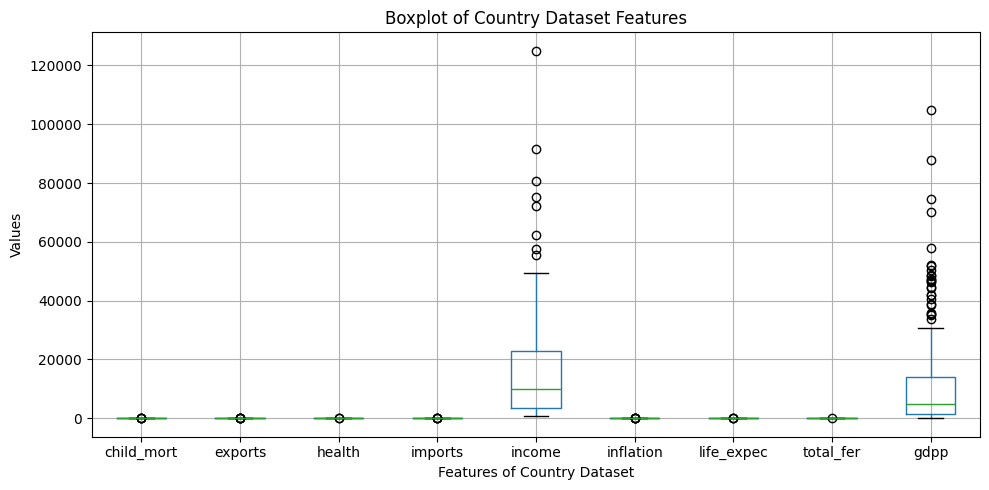

In [7]:
# Boxplot of the dataset to spot outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

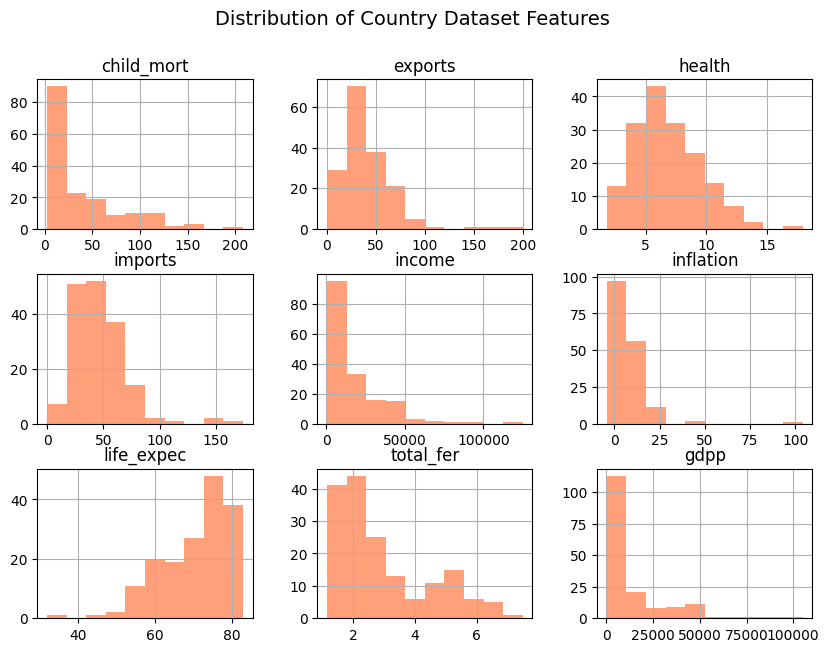

In [8]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

In [9]:
# Feature clipping right skewed features
# Define list of right skewed featutres
features = ['gdpp', 'income', 'child_mort', 'exports', 'imports', 'inflation']

# Feature clip
for feature in features:
    lower_limit, upper_limit = np.percentile(df[feature], [1,95])
    df[feature] = np.clip(df[feature], lower_limit, upper_limit)

# Feature clipping left skewed features
lower_limit, upper_limit = np.percentile(df['life_expec'], [5,100])
df['life_expec'] = np.clip(df['life_expec'], lower_limit, upper_limit)

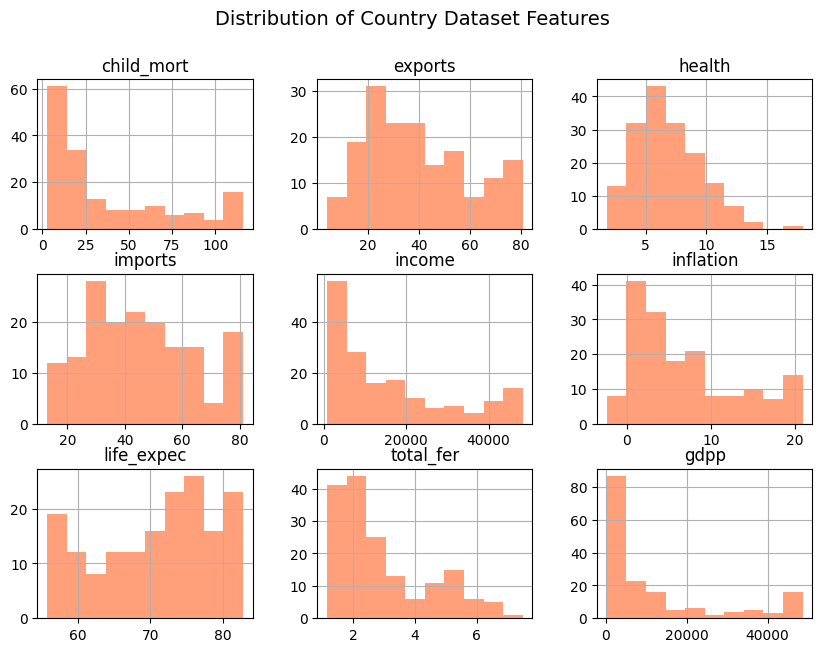

In [10]:
# Histogram of the dataset
df.hist(bins=10, color='#FFA07A', figsize=(10,7))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

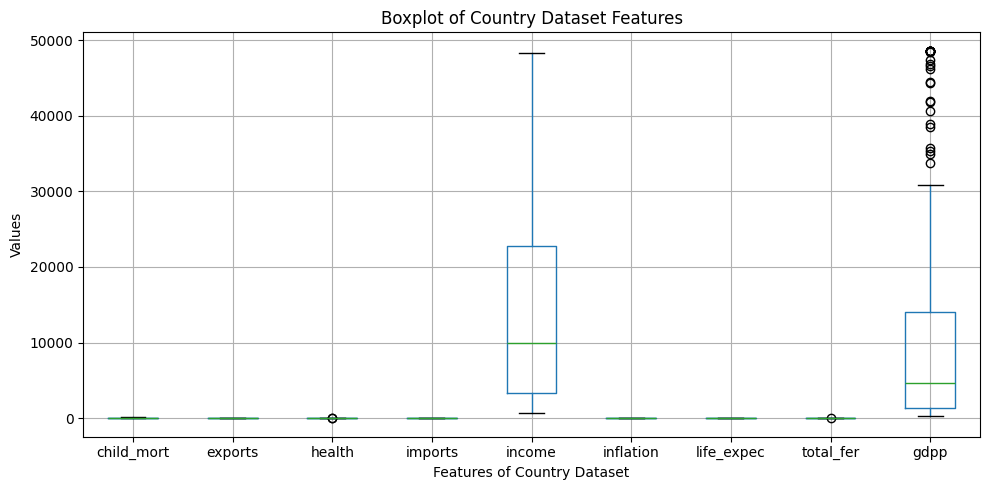

In [11]:
# Boxplot of the dataset to re-check outliers
df.boxplot(figsize=(10,5))

# Add title and labels
plt.title('Boxplot of Country Dataset Features')
plt.xlabel('Features of Country Dataset')
plt.ylabel('Values')

plt.tight_layout()
plt.show()

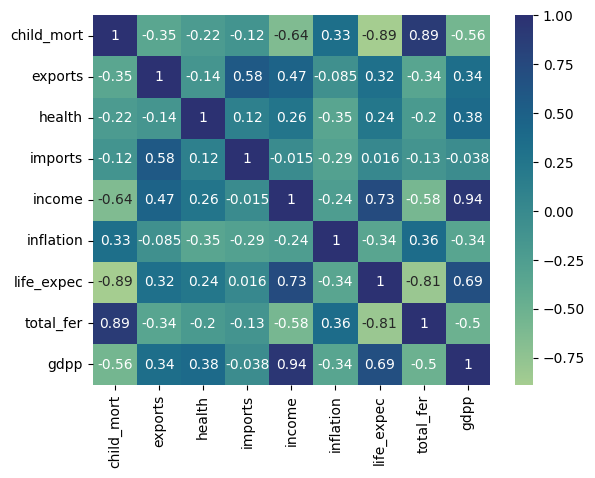

In [12]:
# Features Heapmap to check for for correlation
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='crest')
plt.show()

In [13]:
# Scale the features using Robust Scaler
features = df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [14]:
# Finding the k value
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(scaled_features)
    sse.append(km.inertia_)

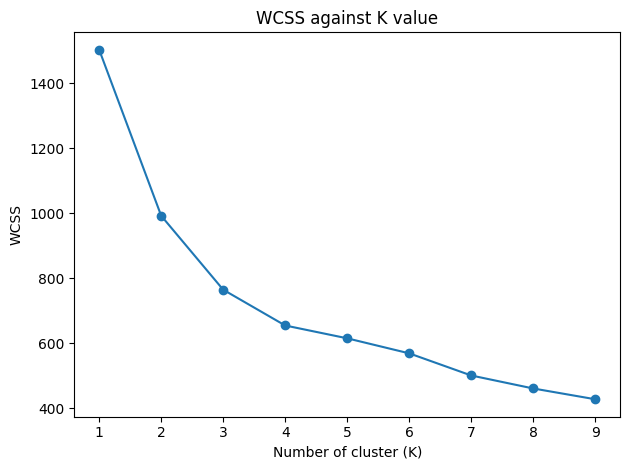

In [15]:
# Plot
plt.plot(k_rng, sse, marker='o')
plt.xlabel('Number of cluster (K)')
plt.ylabel('WCSS')
plt.title('WCSS against K value')
plt.tight_layout()
plt.show()

For n_clusters = 2, average silhouette score = 0.284


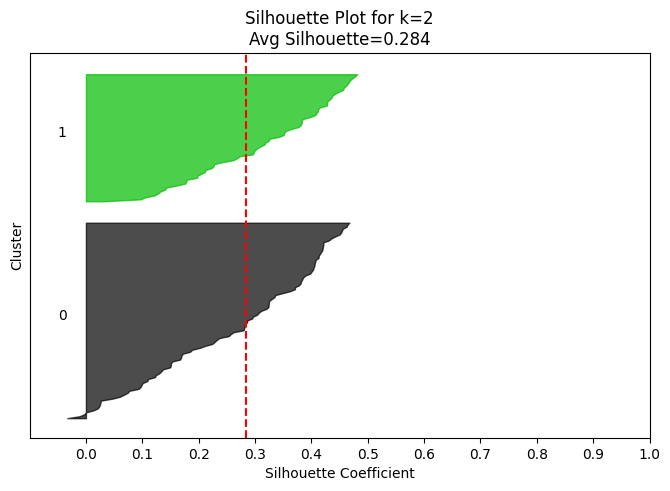

For n_clusters = 3, average silhouette score = 0.273


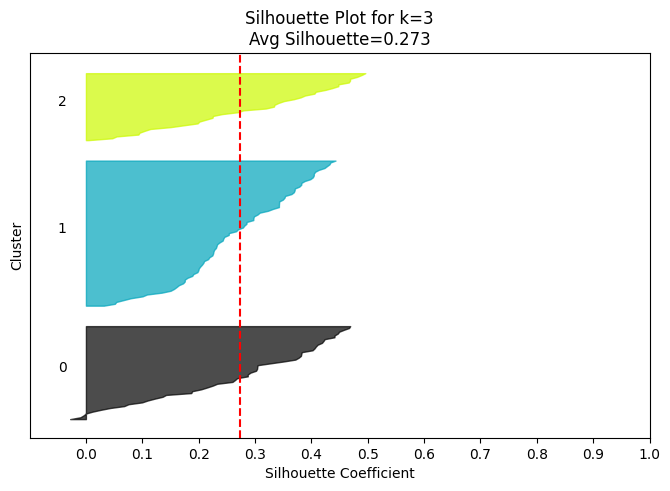

For n_clusters = 4, average silhouette score = 0.268


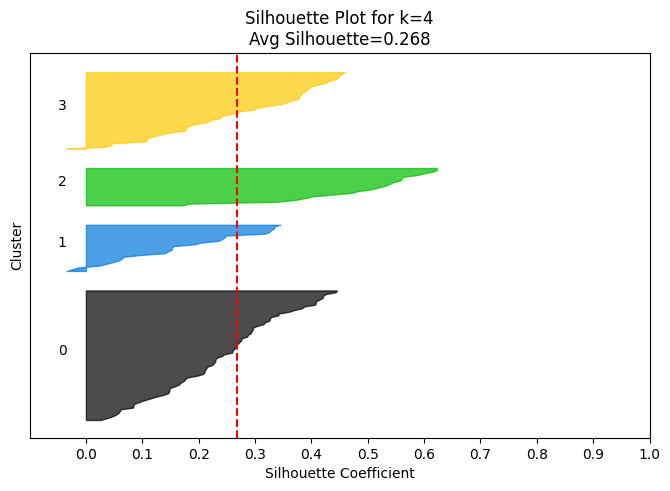

For n_clusters = 5, average silhouette score = 0.258


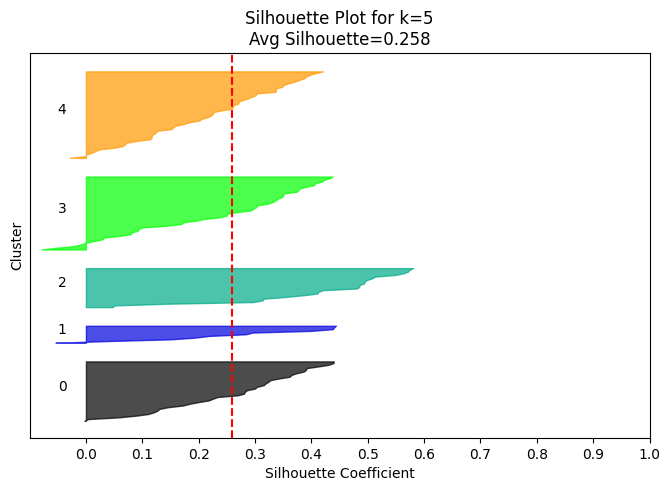

For n_clusters = 6, average silhouette score = 0.250


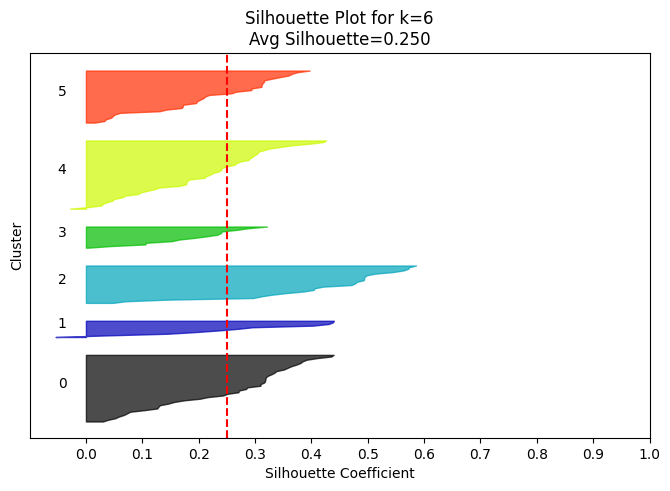

In [16]:
# Visualize Silhoutte scores to to see how well balanced scores are in each of the clusters (for different K value)
# Silhoutte score of closer to 1 is better

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Initialise the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(scaled_features)
    
    # Average silhouette score
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(f"For n_clusters = {n_clusters}, average silhouette score = {silhouette_avg:.3f}")
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)
    
    # Create a subplot for silhouette
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)
    
    # The silhouette coefficient range 
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate silhouette scores for samples in cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        
        # Label the silhouette plots with their cluster number at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute new y_lower for next cluster
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Visualise silhouette score for each K value
    ax1.set_title(f"Silhouette Plot for k={n_clusters}\nAvg Silhouette={silhouette_avg:.3f}")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster")
    
    # The vertical line for average silhouette score of all values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # Clear the y-axis labels
    ax1.set_yticks([])  
    ax1.set_xticks([i/10 for i in range(0, 11)])
    
    plt.show()
    



In [17]:
# Dimensionality reduction
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_features)

In [18]:
# Use the cluster to be 3
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(reduced_data)
y_predicted

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 0, 0, 0, 2, 1, 0, 0, 2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1], dtype=int32)

In [19]:
# put the cluster into the dataframe
df['Cluster'] = y_predicted

df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.44,56.20,5.82,553.0,1
1,Albania,16.6,28.0,6.55,48.6,9930.0,4.49,76.30,1.65,4090.0,2
2,Algeria,27.3,38.4,4.17,31.4,12900.0,16.10,76.50,2.89,4460.0,2
3,Angola,116.0,62.3,2.85,42.9,5900.0,20.87,60.10,6.16,3530.0,1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100.0,1.44,76.80,2.13,12200.0,2
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950.0,2.62,63.00,3.50,2970.0,2
163,Venezuela,17.1,28.5,4.91,17.6,16500.0,20.87,75.40,2.47,13500.0,2
164,Vietnam,23.3,72.0,6.84,80.2,4490.0,12.10,73.10,1.95,1310.0,2
165,Yemen,56.3,30.0,5.18,34.4,4480.0,20.87,67.50,4.67,1310.0,1


In [20]:
# Centroid
km.cluster_centers_

array([[ 2.82012167, -0.45231666,  0.12914383],
       [-2.56038924, -0.1789483 ,  0.217912  ],
       [ 0.19587757,  0.33428881, -0.19891516]])

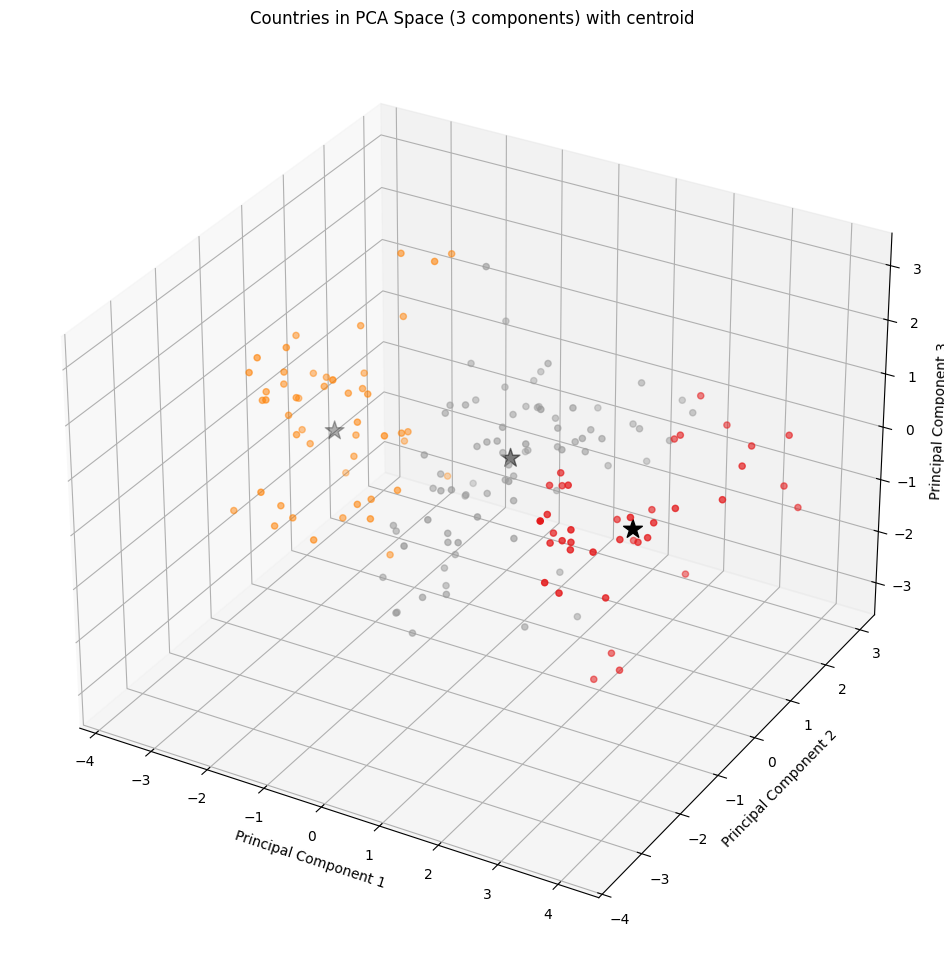

In [21]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot in 3D
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df["Cluster"], cmap="Set1", label='Clusters')

# Plot centroids
ax.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color = 'black', marker='*', s=200, label = 'Centroids')

# Add title and labels
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title("Countries in PCA Space (3 components) with centroid")



plt.show()

In [22]:
# Statistics summary per cluster
numeric_cols = df.select_dtypes(include="number").columns
cluster_summary = df.groupby("Cluster")[numeric_cols].agg(["mean", "median", "min", "max"])
print(cluster_summary)

        child_mort                        exports                         \
              mean median   min    max       mean median      min    max   
Cluster                                                                    
0         5.269231    4.3   2.8   13.8  49.194359   49.4  12.4000  80.57   
1        85.177551   88.2  36.9  116.0  25.654669   22.6   3.9094  80.57   
2        22.330380   18.6   4.5  111.0  42.478228   39.5  10.7000  80.57   

           health         ... total_fer                gdpp           \
             mean median  ...       min   max          mean   median   
Cluster                   ...                                          
0        8.722821   9.40  ...      1.15  3.03  36479.230769  38900.0   
1        6.152449   5.25  ...      2.33  7.49   1351.902857    758.0   
2        6.285570   6.00  ...      1.25  5.21   6518.683544   5080.0   

                           Cluster                 
              min      max    mean median min max  
Cluste

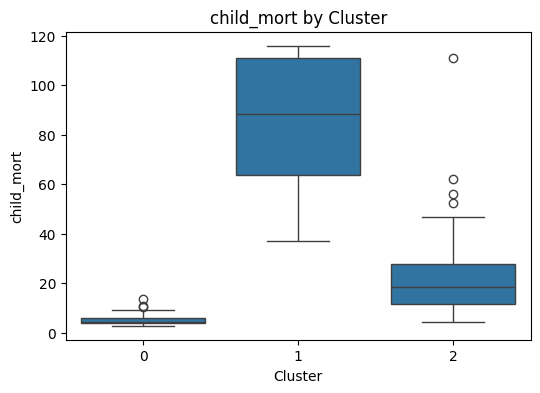

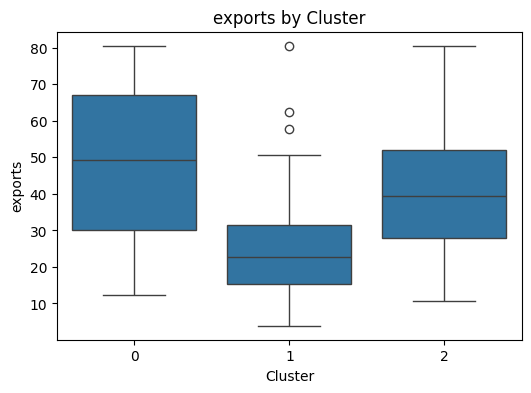

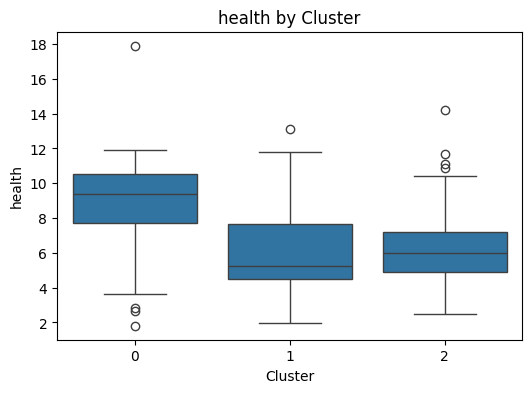

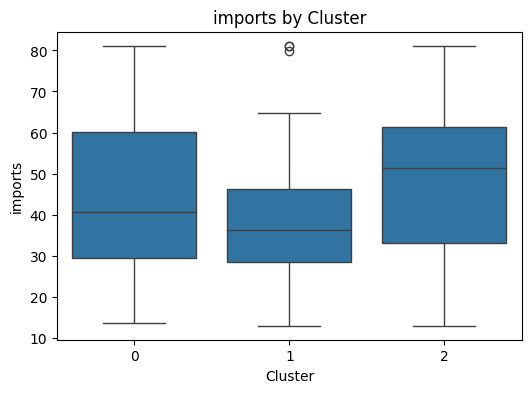

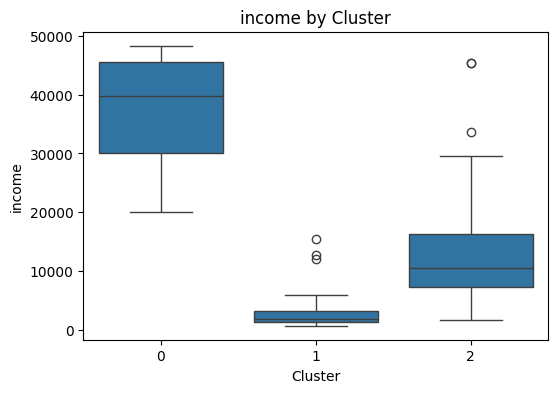

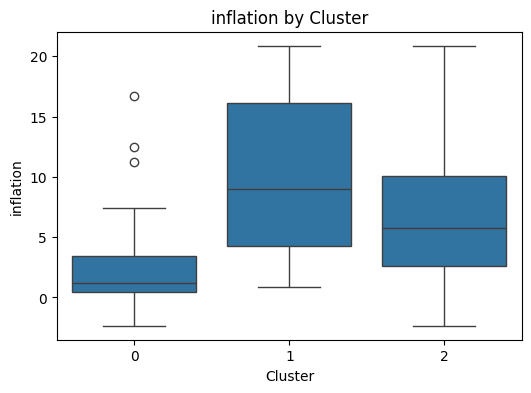

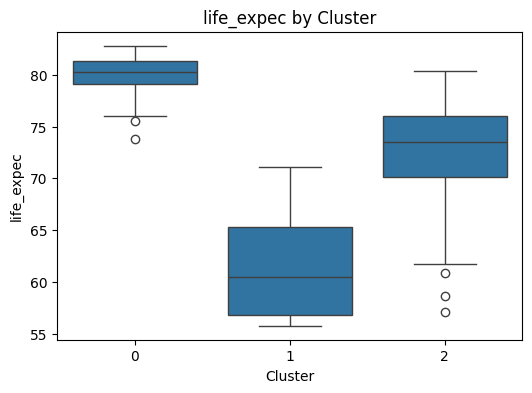

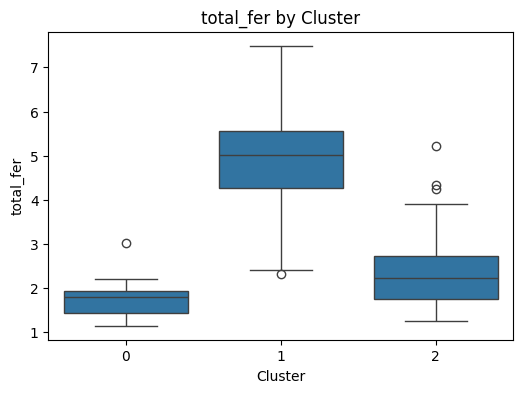

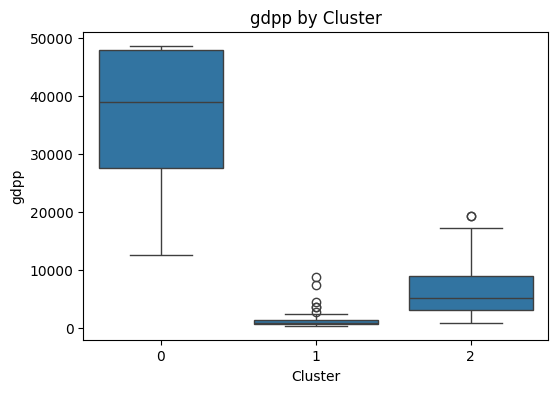

In [23]:
# Check the distribution of each Feature by cluster
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
for feat in features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Cluster", y=feat, data=df)
    plt.title(f"{feat} by Cluster")
    plt.show()

In [24]:
# Compare means side by side

# Extract means of each cluster
mean_values = df.groupby("Cluster")[['income', 'gdpp']].mean()
print(mean_values)
# Transpose - rows: features, columns = cluster
mean_value_transposed = mean_values.T
print(mean_value_transposed)

               income          gdpp
Cluster                            
0        37800.256410  36479.230769
1         2952.622041   1351.902857
2        12780.506329   6518.683544
Cluster             0            1             2
income   37800.256410  2952.622041  12780.506329
gdpp     36479.230769  1351.902857   6518.683544


In [25]:
# Compare means side by side

# Extract means of each cluster
mean_values2 = df.groupby("Cluster")[['child_mort', 'exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer']].mean()
print(mean_values2)
# Transpose - rows: features, columns = cluster
mean_value_transposed2 = mean_values2.T
print(mean_value_transposed2)


         child_mort    exports    health    imports  inflation  life_expec  \
Cluster                                                                      
0          5.269231  49.194359  8.722821  44.760513   2.541646   79.769231   
1         85.177551  25.654669  6.152449  39.670776   9.903776   61.182041   
2         22.330380  42.478228  6.285570  48.917823   7.285053   72.472152   

         total_fer  
Cluster             
0         1.741538  
1         4.839796  
2         2.370127  
Cluster             0          1          2
child_mort   5.269231  85.177551  22.330380
exports     49.194359  25.654669  42.478228
health       8.722821   6.152449   6.285570
imports     44.760513  39.670776  48.917823
inflation    2.541646   9.903776   7.285053
life_expec  79.769231  61.182041  72.472152
total_fer    1.741538   4.839796   2.370127


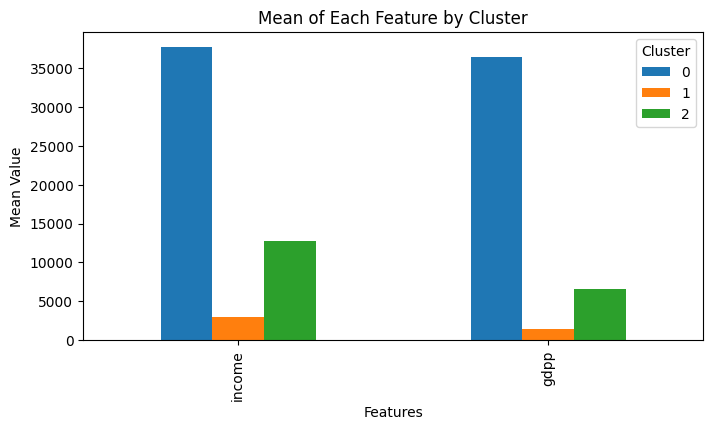

In [26]:
# plot tranposed 
mean_value_transposed.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

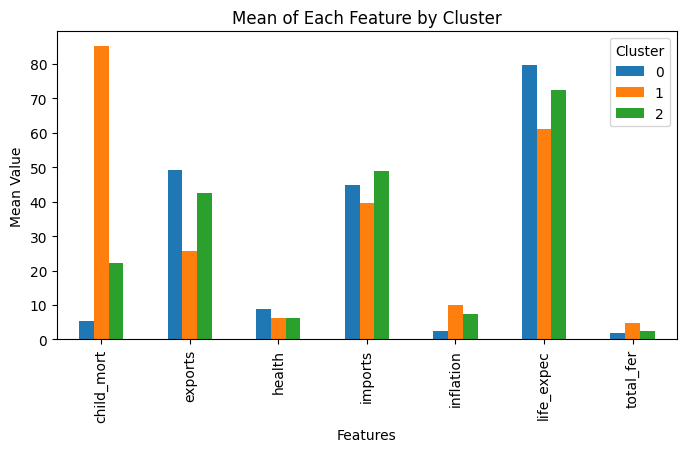

In [27]:
# plot tranposed 
mean_value_transposed2.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

In [28]:
# Filter countries in Cluster 1
cluster_1_countries = df[df["Cluster"] == 1]["country"]

cluster_1_countries

0                   Afghanistan
3                        Angola
12                   Bangladesh
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
69                        India
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106     

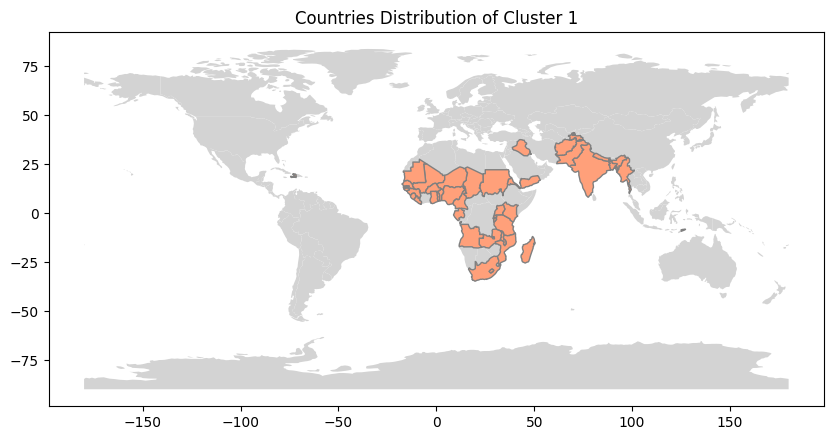

In [29]:
# Visualise the Countries Distribution of Cluster 1, which are the countries that HELP int. should focus on

# Download Natural Earth dataset manually
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_0_countries.geojson")

# Filter world map to show only the countries in cluster_1_countries
selected_countries = world[world["NAME"].isin(cluster_1_countries.unique())]

# Plot the countries
fig, ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax, color="lightgrey") 
selected_countries.plot(ax=ax, color='#FFA07A', edgecolor="grey")

plt.title("Countries Distribution of Cluster 1")
plt.show()



In [30]:
# Print out a list of all the countries in cluster 1
print(df[df["Cluster"] == 1]["country"].unique())

['Afghanistan' 'Angola' 'Bangladesh' 'Benin' 'Burkina Faso' 'Burundi'
 'Cameroon' 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Eritrea' 'Gabon' 'Gambia' 'Ghana' 'Guinea'
 'Guinea-Bissau' 'Haiti' 'India' 'Iraq' 'Kenya' 'Kiribati' 'Lao' 'Lesotho'
 'Liberia' 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Mozambique'
 'Myanmar' 'Nepal' 'Niger' 'Nigeria' 'Pakistan' 'Rwanda' 'Senegal'
 'Sierra Leone' 'South Africa' 'Sudan' 'Tajikistan' 'Tanzania'
 'Timor-Leste' 'Togo' 'Uganda' 'Yemen' 'Zambia']


In [31]:
# Create cluster 1 df
cluster_1_df = df[df["Cluster"] == 1].reset_index(drop=True)
cluster_1_df= cluster_1_df.drop(columns='Cluster')
cluster_1_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0000,7.58,44.900,1610.00,9.440,56.20,5.82,553.00
1,Angola,116.0,62.3000,2.85,42.900,5900.00,20.870,60.10,6.16,3530.00
2,Bangladesh,49.4,16.0000,3.52,21.800,2440.00,7.140,70.40,2.33,758.00
3,Benin,111.0,23.8000,4.10,37.200,1820.00,0.885,61.80,5.36,758.00
4,Burkina Faso,116.0,19.2000,6.74,29.600,1430.00,6.810,57.90,5.87,575.00
5,Burundi,93.6,8.9200,11.60,39.200,764.00,12.300,57.70,6.26,331.62
6,Cameroon,108.0,22.2000,5.13,27.000,2660.00,1.910,57.30,5.11,1310.00
7,Central African Republic,116.0,11.8000,3.98,26.500,888.00,2.010,55.78,5.21,446.00
8,Chad,116.0,36.8000,4.53,43.500,1930.00,6.390,56.50,6.59,897.00
9,Comoros,88.2,16.5000,4.51,51.700,1410.00,3.870,65.90,4.75,769.00


In [32]:
# Checking for null valuses in the new cluster 1 df
cluster_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     49 non-null     object 
 1   child_mort  49 non-null     float64
 2   exports     49 non-null     float64
 3   health      49 non-null     float64
 4   imports     49 non-null     float64
 5   income      49 non-null     float64
 6   inflation   49 non-null     float64
 7   life_expec  49 non-null     float64
 8   total_fer   49 non-null     float64
 9   gdpp        49 non-null     float64
dtypes: float64(9), object(1)
memory usage: 4.0+ KB


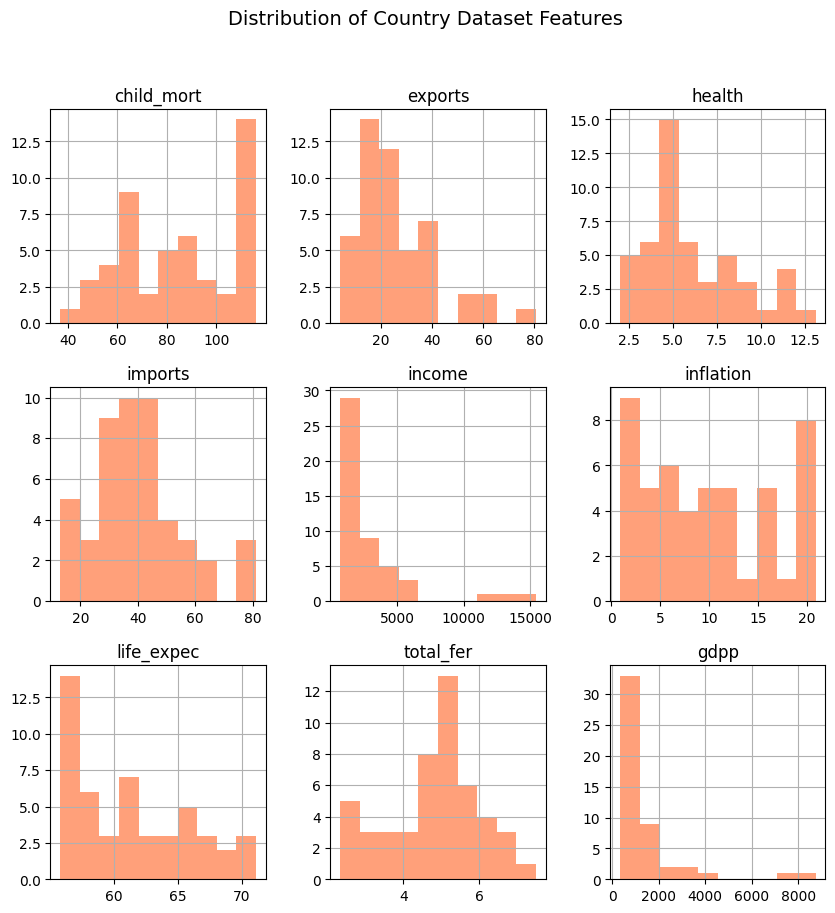

In [33]:
# Histogram of the dataset
cluster_1_df.hist(bins=10, color='#FFA07A', figsize=(10,10))

# Add title
plt.suptitle('Distribution of Country Dataset Features', fontsize=14)

plt.show()

# Hierartical Cluster of Cluster 1

## Narrow down the range of countries

In [34]:
# Standardising the data
scaler = StandardScaler()

features1 = cluster_1_df[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
data_norm = scaler.fit_transform(features1)
data_norm = pd.DataFrame(data_norm, columns=features1.columns)
data_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.210809,-1.014394,0.533779,0.330278,-0.452581,-0.071385,-1.081498,0.822084,-0.489034
1,1.293721,2.374550,-1.234827,0.203958,0.993525,1.687940,-0.234889,1.107238,1.333283
2,-1.501704,-0.625605,-0.984305,-1.128720,-0.172799,-0.425405,2.001029,-2.104933,-0.363547
3,1.083855,-0.120179,-0.767436,-0.156054,-0.381793,-1.388185,0.134146,0.436288,-0.363547
4,1.293721,-0.418251,0.219693,-0.636071,-0.513257,-0.476199,-0.712463,0.864018,-0.475567


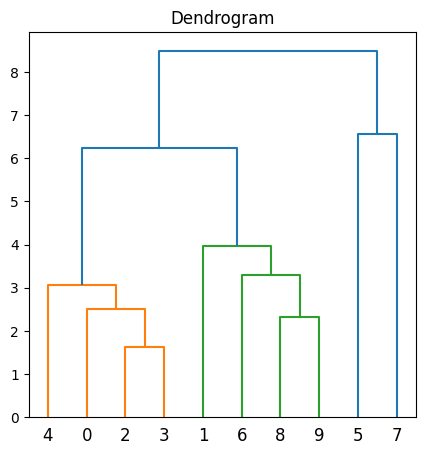

In [35]:
# Dendrogram to find the number of clusters
subset_data = data_norm.sample(n=10)

plt.figure(figsize=(5,5))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(subset_data, method='ward'))
plt.show()

In [36]:
# Using sillhoute score to determine the k value

sil_score = []
k_range = range(2, 11)

for k in k_range:
    cluster = AgglomerativeClustering(n_clusters=k, metric= 'euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(data_norm)


    score = silhouette_score(data_norm, cluster_labels)
    sil_score.append(score)
    print(f'Sillohte score for k={k}: {score}')

Sillohte score for k=2: 0.20141998631233257
Sillohte score for k=3: 0.2275049905851101
Sillohte score for k=4: 0.2428994268948518
Sillohte score for k=5: 0.25969312097088537
Sillohte score for k=6: 0.20697965115065825
Sillohte score for k=7: 0.1904775966179795
Sillohte score for k=8: 0.21106436952365965
Sillohte score for k=9: 0.21786326816498555
Sillohte score for k=10: 0.21944393187013894


In [37]:
# Dimensionality reduction
pca = PCA(n_components=3)
reduced_data2 = pca.fit_transform(data_norm)

In [38]:
reduced_data2

array([[-1.51544614e+00,  3.78029295e-02,  5.40533969e-02],
       [ 1.28291884e+00,  3.42512811e+00, -9.07858559e-01],
       [ 1.85270049e+00, -2.94414732e+00, -5.34139379e-01],
       [-1.05838213e+00, -9.92111895e-02, -7.63498241e-01],
       [-1.56503046e+00,  4.43085544e-01, -8.62937578e-01],
       [-1.90177442e+00,  3.85201553e-02,  3.39716074e-01],
       [-8.83202928e-01,  2.53730704e-01, -6.85510596e-01],
       [-1.70328454e+00, -1.34454891e-01, -1.28377932e+00],
       [-1.50889439e+00,  1.60841229e+00, -7.58835884e-01],
       [-5.14485325e-01, -1.11736741e+00,  2.92223157e-03],
       [-1.49005022e+00,  2.05539000e+00, -3.76164659e-01],
       [ 2.18706433e+00,  2.68506283e+00,  2.73461523e-01],
       [-8.38185658e-01,  1.69663808e+00,  1.97905867e-02],
       [ 4.30455636e-01, -1.70134367e+00, -1.45862873e+00],
       [ 5.95550842e+00,  2.90609181e+00,  4.55476684e-01],
       [-5.20100399e-01, -6.86374619e-01, -2.55168141e-01],
       [ 6.94167483e-01, -1.34788495e-02

In [50]:
# Agglomerative clustering
clus = AgglomerativeClustering(n_clusters=5, metric= 'euclidean', linkage='ward')
y_predicted2 = clus.fit_predict(reduced_data2)

In [51]:
y_predicted2

array([2, 3, 0, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 0, 1, 0, 0, 2, 2, 2, 0, 1,
       0, 4, 0, 4, 4, 0, 2, 2, 3, 2, 0, 0, 2, 3, 0, 0, 0, 2, 1, 0, 0, 0,
       0, 2, 2, 0, 3])

In [52]:
# Put the cluster into the cluster_1_dataframe
cluster_1_df['Cluster'] = y_predicted2
cluster_1_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610.0,9.440,56.2,5.82,553.0,2
1,Angola,116.0,62.3,2.85,42.9,5900.0,20.870,60.1,6.16,3530.0,3
2,Bangladesh,49.4,16.0,3.52,21.8,2440.0,7.140,70.4,2.33,758.0,0
3,Benin,111.0,23.8,4.10,37.2,1820.0,0.885,61.8,5.36,758.0,2
4,Burkina Faso,116.0,19.2,6.74,29.6,1430.0,6.810,57.9,5.87,575.0,2


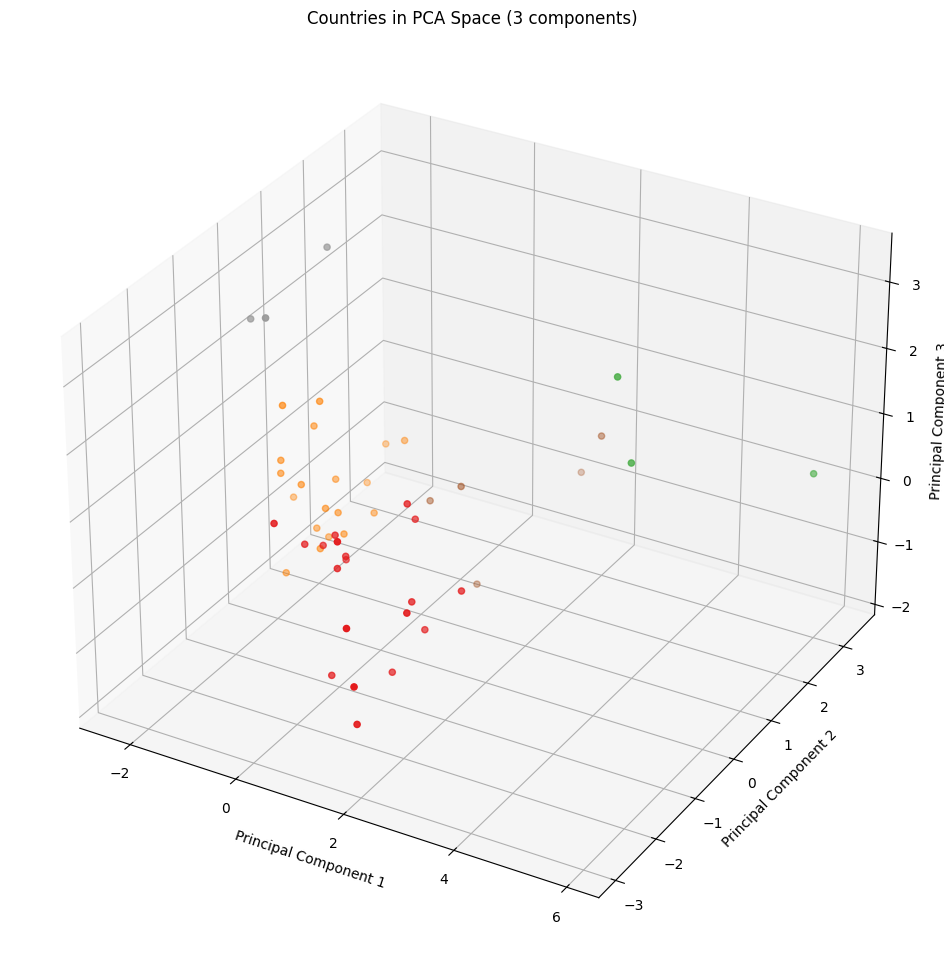

In [53]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot in 3D
scatter = ax.scatter(reduced_data2[:, 0], reduced_data2[:, 1], reduced_data2[:, 2], c=cluster_1_df["Cluster"], cmap="Set1", label='Clusters')

# Add title and labels
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.title("Countries in PCA Space (3 components)")

plt.show()

In [54]:
# Compare means side by side

# Extract means of each cluster
mean_values01 = cluster_1_df.groupby("Cluster")[['income', 'gdpp']].mean()
print(mean_values01)

# Transpose - rows: features, columns = cluster
mean_value_transposed01 = mean_values01.T
print(mean_value_transposed01)

               income         gdpp
Cluster                           
0         2614.210526  1040.210526
1        13366.666667  6843.333333
2         1432.433684   615.664211
3         4568.000000  2252.000000
4         1617.413333   997.206667
Cluster            0             1            2       3            4
income   2614.210526  13366.666667  1432.433684  4568.0  1617.413333
gdpp     1040.210526   6843.333333   615.664211  2252.0   997.206667


In [55]:
# Compare means side by side

# Extract means of each cluster
mean_values02 = cluster_1_df.groupby("Cluster")[['child_mort', 'exports', 'health', 'imports', 'inflation', 'life_expec', 'total_fer']].mean()
print(mean_values02)

# Transpose - rows: features, columns = cluster
mean_value_transposed02 = mean_values02.T
print(mean_value_transposed02)


         child_mort    exports     health    imports  inflation  life_expec  \
Cluster                                                                       
0         66.510526  18.178358   5.096316  33.925684  10.166316   65.373684   
1         51.433333  41.900000   6.950000  26.800000  13.183333   61.960000   
2        106.715789  24.122105   6.784737  40.505263   7.689211   57.246316   
3         95.280000  51.174000   4.136000  41.420000  19.068000   60.996000   
4         83.900000  23.933333  11.400000  80.726667   3.713333   59.093333   

         total_fer  
Cluster             
0         4.186842  
1         3.743333  
2         5.625263  
3         5.466000  
4         4.053333  
Cluster             0          1           2       3          4
child_mort  66.510526  51.433333  106.715789  95.280  83.900000
exports     18.178358  41.900000   24.122105  51.174  23.933333
health       5.096316   6.950000    6.784737   4.136  11.400000
imports     33.925684  26.800000   40.50526

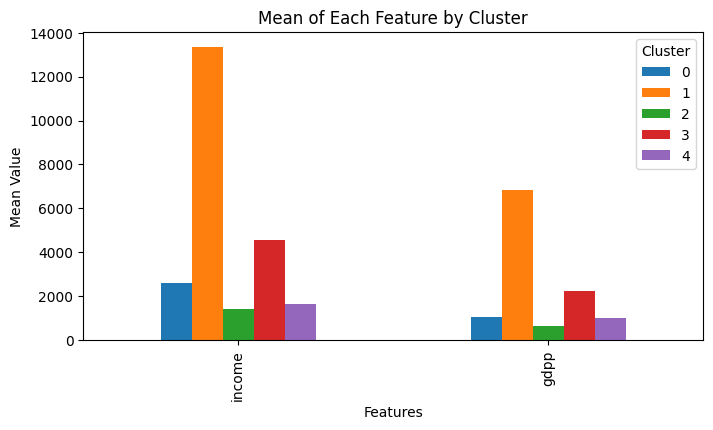

In [58]:
# plot tranposed 
mean_value_transposed01.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

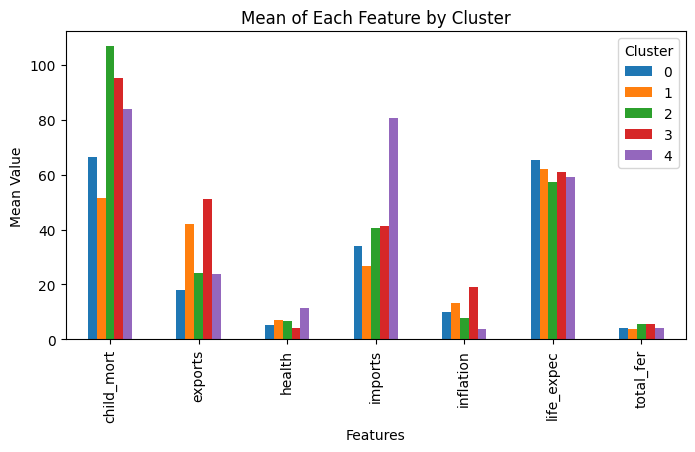

In [59]:
# plot tranposed 
mean_value_transposed02.plot.bar(figsize=(8,4))
plt.title("Mean of Each Feature by Cluster")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.show()

In [62]:
# Filter countries in Cluster 2
cluster_2_countries = cluster_1_df[cluster_1_df["Cluster"] == 2]["country"]

cluster_2_countries

0                  Afghanistan
3                        Benin
4                 Burkina Faso
5                      Burundi
6                     Cameroon
7     Central African Republic
8                         Chad
10            Congo, Dem. Rep.
12               Cote d'Ivoire
17                      Guinea
18               Guinea-Bissau
19                       Haiti
28                      Malawi
29                        Mali
31                  Mozambique
34                       Niger
39                Sierra Leone
45                        Togo
46                      Uganda
Name: country, dtype: object

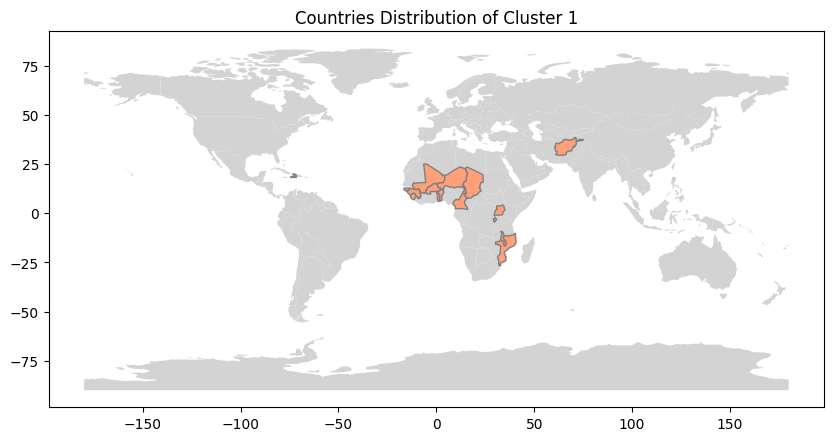

In [63]:
# Visualise the Countries Distribution of Cluster 2, which are the countries that HELP int. should focus on

# Download Natural Earth dataset manually
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_110m_admin_0_countries.geojson")

# Filter world map to show only the countries in cluster_1_countries
selected_countries01 = world[world["NAME"].isin(cluster_2_countries.unique())]

# Plot the countries
fig, ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax, color="lightgrey") 
selected_countries01.plot(ax=ax, color='#FFA07A', edgecolor="grey")

plt.title("Countries Distribution of Cluster 1")
plt.show()